In [62]:
import numpy as np
import pandas as pd

train = pd.read_csv("/Users/xinchengzhu/Downloads/train.csv")

In [63]:
# Filter missing data and useless columns
train = train[train["MISSING_DATA"] == False]
train = train[train["POLYLINE"].map(len) > 1]
train = train[train["POLYLINE"] != "[]"]
train = train[["POLYLINE"]]
# Choose 10000 rows randomly from dataset to run
train_1 = train.sample(10000)

train_1

,POLYLINE
1165211,"[[-8.628219,41.165046],[-8.62839,41.164956],[-..."
1177678,"[[-8.630451,41.167944]]"
1609640,"[[-8.585793,41.148954],[-8.586387,41.14899],[-..."
1319474,"[[-8.613675,41.141556],[-8.613846,41.141142],[..."
471524,"[[-8.648217,41.154408],[-8.647191,41.155362],[..."
...,...
1347818,"[[-8.614701,41.140917],[-8.614053,41.14116],[-..."
1383609,"[[-8.609661,41.160222],[-8.609643,41.160258],[..."
1248515,"[[-8.644932,41.162706],[-8.64495,41.162958],[-..."
244641,"[[-8.639991,41.159637],[-8.639955,41.159646],[..."


In [64]:
def _change_type(polyline):
    polyline = polyline[2:-2]
    cords_raw = polyline.split("],[")
    cords = []
    max_lon, min_lon, max_lat, min_lat = float("-inf"), float("inf"), float("-inf"), float("inf")
    for cord in cords_raw:
        cords.append([float(loc) for loc in cord.split(",")])
        max_lon = max(max_lon, cords[-1][0])
        min_lon = min(min_lon, cords[-1][0])
        max_lat = max(max_lat, cords[-1][1])
        min_lat = min(min_lat, cords[-1][1])
    return pd.Series({"POLYLINE": cords, "max_lon": max_lon, "min_lon": min_lon, "max_lat": max_lat, "min_lat": min_lat})

In [71]:
def filter_map(train, max_lat, min_lat, max_long, min_long):
    changed = train["POLYLINE"].apply(_change_type)
    changed.reset_index(drop=True,inplace=True)
    for i in range(len(changed)):
        for cord in changed.iloc[i]['POLYLINE']:
            if cord[0] in range(min_long, max_long) and cord[1] in range(min_lat, max_lat):
                changed["check"] = 1
            else:
                changed["check"] = 0
    return changed[changed["check"] == 1]


,POLYLINE,max_lon,min_lon,max_lat,min_lat,check


In [4]:
def _normalize(polyline, max_lon, min_lon, max_lat, min_lat):
    final = [[(cord[0]-min_lon)/(max_lon-min_lon), (cord[1] - min_lat) / (max_lat - min_lat)] for cord in polyline]
    return pd.Series({"POLYLINE_INIT": final[:-1], "POLYLINE_DEST": final[-1]})

In [5]:
def _to_matrix(polyline, m):
    mat = np.zeros((m, m))
    n = len(polyline)
    for i in range(n):
        x = min(m - 1, int(polyline[i][0] * m))
        y = min(m - 1, int(polyline[i][1] * m))
        mat[y][x] = (i + 1) / n
    return mat

In [6]:
def transform(df_train, m):
    # Change type
    changed = df_train["POLYLINE"].apply(_change_type)
    df_train["POLYLINE"] = changed["POLYLINE"]
    # Get min-max
    max_longitude = changed["max_lon"].max()
    min_longitude = changed["min_lon"].min()
    max_latitude = changed["max_lat"].max()
    min_latitude = changed["min_lat"].min()
    # Normalize min-max and split
    cleaned = train_1["POLYLINE"].apply(_normalize, args=(max_longitude, min_longitude, max_latitude, min_latitude))
    # Transform to matrices
    cleaned["MATRIX"] = cleaned["POLYLINE_INIT"].apply(_to_matrix, args=(m,))
    return cleaned

In [7]:
transformed = transform(train_1, 256)

In [8]:
import matplotlib.pyplot as plt

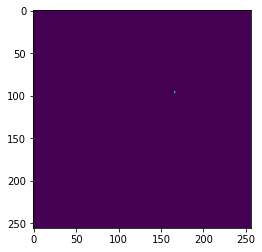

In [9]:
mat = transformed["MATRIX"].iloc[0]

plt.imshow(mat)
plt.show()

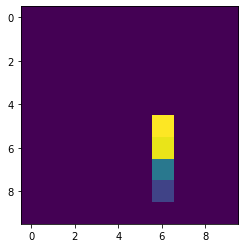

In [10]:
plt.imshow(mat[90:100, 160:170])
plt.show()

In [37]:
for i in range(len(train_1)):
    for cord in train_1.iloc[i]['POLYLINE']:
        if cord[0] in range(1, 4) and cord[1] in range(1, 5):
            pass
        else:
            train_1.drop([train_1.index[i]], inplace=True)

IndexError: index 7 is out of bounds for axis 0 with size 7

In [69]:
train_1.drop([train_1.index[0]],inplace=True)
train_1

,POLYLINE,index
1,"[[-8.630451,41.167944]]",1
2,"[[-8.585793,41.148954],[-8.586387,41.14899],[-...",2
3,"[[-8.613675,41.141556],[-8.613846,41.141142],[...",3
4,"[[-8.648217,41.154408],[-8.647191,41.155362],[...",4
5,"[[-8.589267,41.169717],[-8.589267,41.169825],[...",5
...,...,...
9995,"[[-8.614701,41.140917],[-8.614053,41.14116],[-...",9995
9996,"[[-8.609661,41.160222],[-8.609643,41.160258],[...",9996
9997,"[[-8.644932,41.162706],[-8.64495,41.162958],[-...",9997
9998,"[[-8.639991,41.159637],[-8.639955,41.159646],[...",9998


In [66]:
train_1.reset_index(drop=True,inplace=True)
train_1

,POLYLINE
0,"[[-8.628219,41.165046],[-8.62839,41.164956],[-..."
1,"[[-8.630451,41.167944]]"
2,"[[-8.585793,41.148954],[-8.586387,41.14899],[-..."
3,"[[-8.613675,41.141556],[-8.613846,41.141142],[..."
4,"[[-8.648217,41.154408],[-8.647191,41.155362],[..."
...,...
9995,"[[-8.614701,41.140917],[-8.614053,41.14116],[-..."
9996,"[[-8.609661,41.160222],[-8.609643,41.160258],[..."
9997,"[[-8.644932,41.162706],[-8.64495,41.162958],[-..."
9998,"[[-8.639991,41.159637],[-8.639955,41.159646],[..."


In [67]:
train_1["index"] = range(len(train_1))
train_1

,POLYLINE,index
0,"[[-8.628219,41.165046],[-8.62839,41.164956],[-...",0
1,"[[-8.630451,41.167944]]",1
2,"[[-8.585793,41.148954],[-8.586387,41.14899],[-...",2
3,"[[-8.613675,41.141556],[-8.613846,41.141142],[...",3
4,"[[-8.648217,41.154408],[-8.647191,41.155362],[...",4
...,...,...
9995,"[[-8.614701,41.140917],[-8.614053,41.14116],[-...",9995
9996,"[[-8.609661,41.160222],[-8.609643,41.160258],[...",9996
9997,"[[-8.644932,41.162706],[-8.64495,41.162958],[-...",9997
9998,"[[-8.639991,41.159637],[-8.639955,41.159646],[...",9998
